[AirQo Ugandan Air Quality Forecast Challenge](https://zindi.africa/competitions/airqo-ugandan-air-quality-forecast-challenge)
===========================================
### Modelos XGBoost con H2o en R

[Edimer David Jaramillo ](https://edimer.github.io/)  
Abril de 2020

## Instalación de H2o y carga de bibliotecas

In [0]:
install.packages("h2o", dependencies = TRUE)
library(h2o)
library(tidyverse)

## Cargando datos

In [0]:
load("/content/df_acha_train.Rdata")
load("/content/df_acha_test.Rdata")

## Distribución de variable respuesta

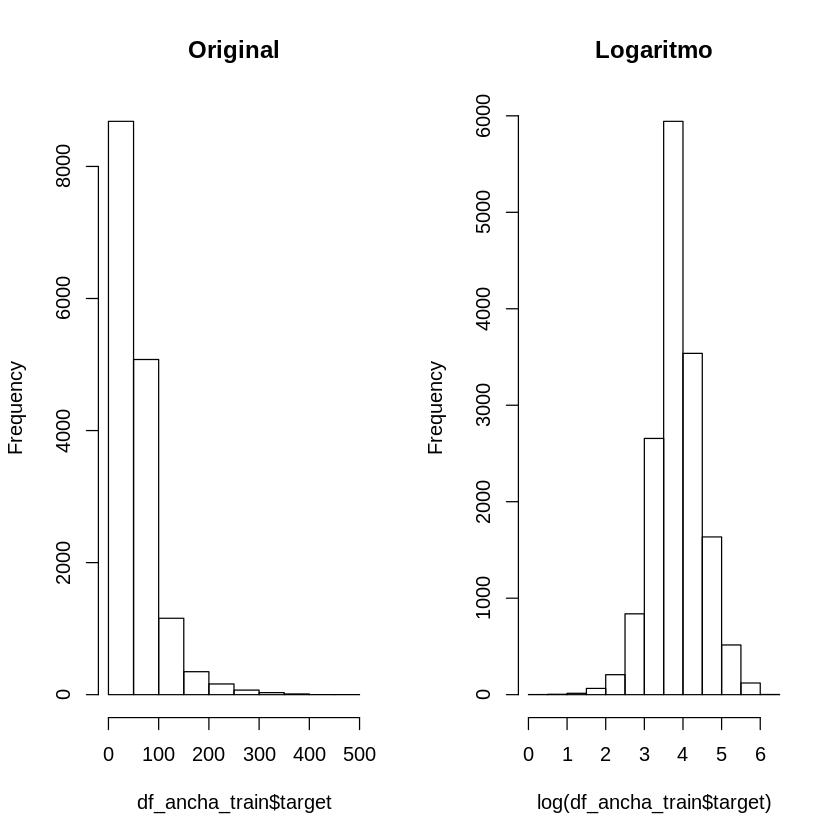

In [8]:
par(mfrow = c(1, 2))
hist(df_ancha_train$target, main = "Original")
hist(log(df_ancha_train$target), main = "Logaritmo")

## Preparación de datos

In [9]:
# Iniciando h2o
h2o.init(nthreads = -1, port = 54321, max_mem_size = "10g")

# df_train y df_test
df_train <- df_ancha_train %>% 
  select(-ID)

datos_h2o <- as.h2o(x = df_train, destination_frame = "datos_h2o")
particiones <- h2o.splitFrame(data = datos_h2o, ratios = c(0.7, 0.20),
                              seed = 123)
datos_train_h2o <- h2o.assign(data = particiones[[1]], key = "datos_train_h2o")
datos_val_h2o   <- h2o.assign(data = particiones[[2]], key = "datos_val_h2o")
datos_test_h2o  <- h2o.assign(data = particiones[[3]], key = "datos_test_h2o")

# Variable respuesta y predictores
var_respuesta <- "target"
predictores   <- setdiff(h2o.colnames(datos_train_h2o), var_respuesta)


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    /tmp/RtmpHCrrKs/file7d59c872ca/h2o_UnknownUser_started_from_r.out
    /tmp/RtmpHCrrKs/file7d12721f10/h2o_UnknownUser_started_from_r.err


Starting H2O JVM and connecting: .. Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         2 seconds 534 milliseconds 
    H2O cluster timezone:       Etc/UTC 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.30.0.1 
    H2O cluster version age:    11 days  
    H2O cluster name:           H2O_started_from_R_root_kqf638 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   10.00 GB 
    H2O cluster total cores:    2 
    H2O cluster allowed cores:  2 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:        

## Modelo XGBoost

In [10]:
xgb <- h2o.xgboost(x = predictores
                  ,y = var_respuesta
                  ,training_frame = datos_train_h2o
                  ,validation_frame = datos_val_h2o
                  ,model_id = "xgb1"
                  ,stopping_rounds = 20
                  ,stopping_metric = "RMSE"
                  ,distribution = "gaussian"
                  ,score_tree_interval = 1
                  ,learn_rate=0.05
                  ,ntrees=10000
                  ,subsample = 0.9
                  ,colsample_bytree = 1
                  ,tree_method = "hist"
                  ,grow_policy = "lossguide"
                  ,booster = "gbtree"
                  ,gamma = 0 #default
                  ,nfolds = 10
                  ,seed = 123
                  ,max_depth = 0 #without limit
                  ,min_rows = 50 #alias min_child_weight
                  ,max_leaves = 350
                  ,max_bins = 256 #(default)
                  ,min_sum_hessian_in_leaf = 100
                  ,max_runtime_secs = 3600)

  |======================================================================| 100%


## Resultados del modelo XGBoost

In [11]:
xgb

Model Details:

H2ORegressionModel: xgboost
Model ID:  xgb1 
Model Summary: 
  number_of_trees
1             223


H2ORegressionMetrics: xgboost
** Reported on training data. **

MSE:  79.08691
RMSE:  8.893082
MAE:  4.309121
RMSLE:  0.1116646
Mean Residual Deviance :  79.08691


H2ORegressionMetrics: xgboost
** Reported on validation data. **

MSE:  743.1994
RMSE:  27.26168
MAE:  17.76496
RMSLE:  0.4146458
Mean Residual Deviance :  743.1994


H2ORegressionMetrics: xgboost
** Reported on cross-validation data. **
** 10-fold cross-validation on training data (Metrics computed for combined holdout predictions) **

MSE:  815.6341
RMSE:  28.55931
MAE:  18.27917
RMSLE:  0.4162964
Mean Residual Deviance :  815.6341


Cross-Validation Metrics Summary: 
                            mean          sd cv_1_valid cv_2_valid cv_3_valid
mae                    18.292095   0.5320338  18.191479  18.078835  17.476606
mean_residual_deviance 818.02783   113.50175   825.6199   790.7589   667.7101
mse        

## Predicciones

In [15]:
# Train
predichos_train <- h2o.predict(xgb, datos_train_h2o) %>%
  as.data.frame() %>% pull(predict)

# Test (Train)
predichos_test <- h2o.predict(xgb, datos_test_h2o) %>%
  as.data.frame() %>% pull(predict)

# Test (Submission)
predichos_subm <- h2o.predict(xgb, as.h2o(df_ancha_test)) %>%
  as.data.frame() %>% pull(predict)

df_ancha_test %>% 
  select(ID) %>% 
  mutate(target = predichos_subm) ->
  subm8

# Exportando predicciones
write.csv(subm8, file = "subm8.csv", row.names = FALSE)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


## RMSE Train y Test (train)

In [16]:
# Función
RMSE <- function(pred, obs, na.rm = FALSE){
  sqrt(mean((pred - obs)^2, na.rm = na.rm))
}

data.frame(
  data = c("Train", "Test"),
  RMSE = c(RMSE(pred = predichos_train, obs = as.vector(datos_train_h2o$target)),
           RMSE(pred = predichos_test, obs = as.vector(datos_test_h2o$target)))
)

data,RMSE
<fct>,<dbl>
Train,8.893082
Test,27.922007


## Importancia de variables

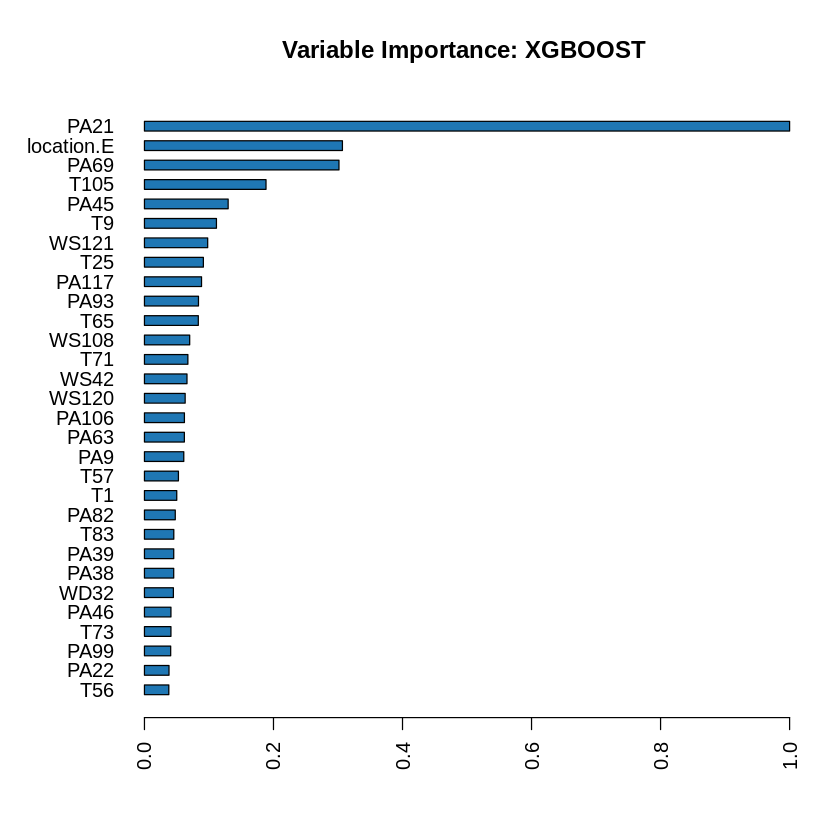

In [17]:
h2o.varimp_plot(xgb, num_of_features = 30)

## Guardando modelo

In [0]:
h2o.saveModel(xgb, path = "XGB_S8", force = TRUE)

## Modelo XGBoost con Regularización

In [18]:
xgb <- h2o.xgboost(x = predictores
                  ,y = var_respuesta
                  ,training_frame = datos_train_h2o
                  ,validation_frame = datos_val_h2o
                  ,model_id = "xgb2"
                  ,stopping_rounds = 20
                  ,stopping_metric = "RMSE"
                  ,distribution = "gaussian"
                  ,score_tree_interval = 1
                  ,learn_rate=0.05
                  ,ntrees=10000
                  ,subsample = 0.9
                  ,colsample_bytree = 1
                  ,tree_method = "hist"
                  ,grow_policy = "lossguide"
                  ,booster = "gbtree"
                  ,gamma = 1 
                  ,reg_alpha = 0.1
                  ,nfolds = 10
                  ,seed = 123
                  ,max_depth = 0 #without limit
                  ,min_rows = 50 #alias min_child_weight
                  ,max_leaves = 350
                  ,max_bins = 256 #(default)
                  ,min_sum_hessian_in_leaf = 100 #default
                  ,max_runtime_secs = 3600)

  |======================================================================| 100%


## Predicciones

In [21]:
# Train
predichos_train <- h2o.predict(xgb, datos_train_h2o) %>%
  as.data.frame() %>% pull(predict)

# Test (Train)
predichos_test <- h2o.predict(xgb, datos_test_h2o) %>%
  as.data.frame() %>% pull(predict)

# Test (Submission)
predichos_subm <- h2o.predict(xgb, as.h2o(df_ancha_test)) %>%
  as.data.frame() %>% pull(predict)

df_ancha_test %>% 
  select(ID) %>% 
  mutate(target = predichos_subm) ->
  subm9

# Exportando predicciones
write.csv(subm9, file = "subm9.csv", row.names = FALSE)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


## RMSE train y test (train)

In [22]:
# Función
RMSE <- function(pred, obs, na.rm = FALSE){
  sqrt(mean((pred - obs)^2, na.rm = na.rm))
}

data.frame(
  data = c("Train", "Test"),
  RMSE = c(RMSE(pred = predichos_train, obs = as.vector(datos_train_h2o$target)),
           RMSE(pred = predichos_test, obs = as.vector(datos_test_h2o$target)))
)

data,RMSE
<fct>,<dbl>
Train,8.823295
Test,27.989875


## Importancia de variables

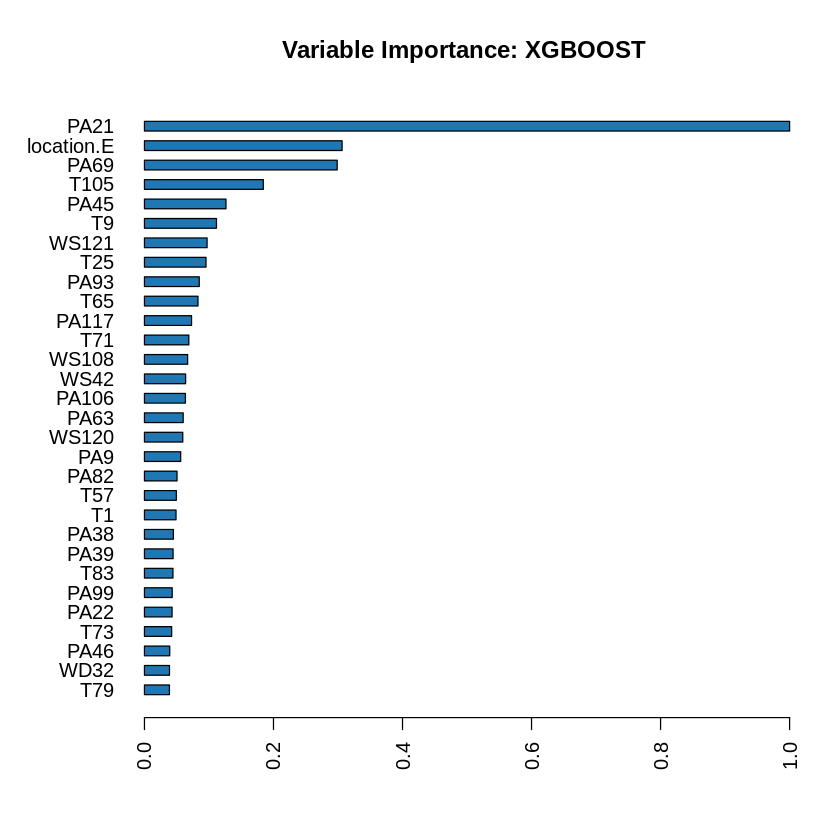

In [23]:
h2o.varimp_plot(xgb, num_of_features = 30)

## Exportando modelo

In [24]:
h2o.saveModel(xgb, path = "XGB_S9", force = TRUE)

[1] "/content/XGB_S9/xgb2"